In [357]:
from sklearn.datasets import load_diabetes

In [358]:
data = load_diabetes()
df_X = data.data
df_y = data.target
print(data.feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


  feature  pearson_corr_with_y
0     bmi             0.586450
1      s5             0.565883
2      bp             0.441482
3      s4             0.430453
4      s6             0.382483
5      s1             0.212022
6     age             0.187889
7      s2             0.174054
8     sex             0.043062
9      s3            -0.394789


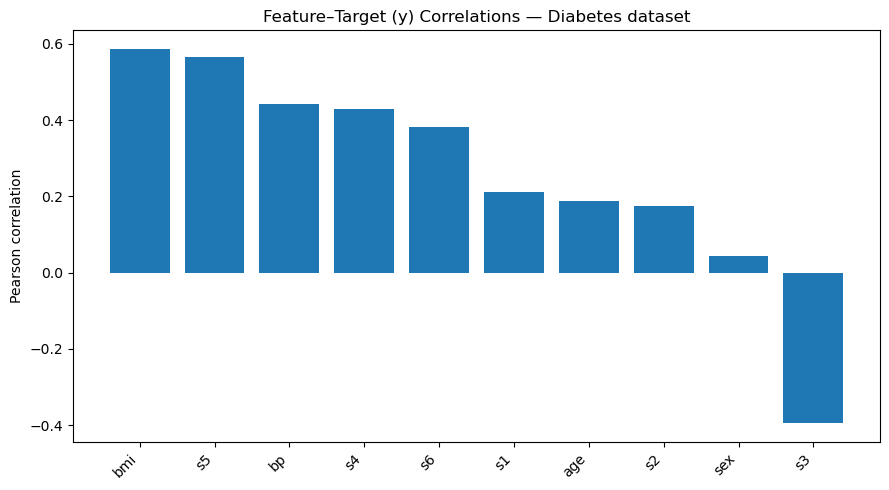

In [359]:
# X–y 상관계수 계산 & 막대그래프
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

# 1) 데이터 로드 → pandas로 변환

data = load_diabetes()
df_X = pd.DataFrame(data.data, columns=data.feature_names)  # 10개 feature
df_y = pd.Series(data.target, name="y")                     # target

# 2) 피어슨 상관계수(각 feature vs y)
corr = df_X.corrwith(df_y)  # Series: index=feature, value=corr
corr_df = corr.sort_values(ascending=False).reset_index()
corr_df.columns = ["feature", "pearson_corr_with_y"]
print(corr_df)  # 표 출력

# 3) 막대그래프
plt.figure(figsize=(9, 5))
plt.bar(corr_df["feature"], corr_df["pearson_corr_with_y"])
plt.title("Feature–Target (y) Correlations — Diabetes dataset")
plt.ylabel("Pearson correlation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# 4) 필요 시 저장
plt.savefig("diabetes_x_y_correlations.png", dpi=150, bbox_inches="tight")
plt.show()


In [360]:
# 상관관계가 0.3 이하는 거의 관계가 없는 것이므로 0.3이상인 변수만 df_X에 넣기

import pandas as pd

# df_X: (N, M) DataFrame, df_y: (N,) Series 라고 가정
corr = df_X.corrwith(pd.Series(df_y, name="y"))   # 각 feature vs y 상관

keep_cols = corr[corr >= 0.5].index.tolist()      # 기준: r >= 0.3
df_X = df_X[keep_cols].copy()

print("선택된 컬럼:", keep_cols)
print("df_X.shape:", df_X.shape)


선택된 컬럼: ['bmi', 's5']
df_X.shape: (442, 2)


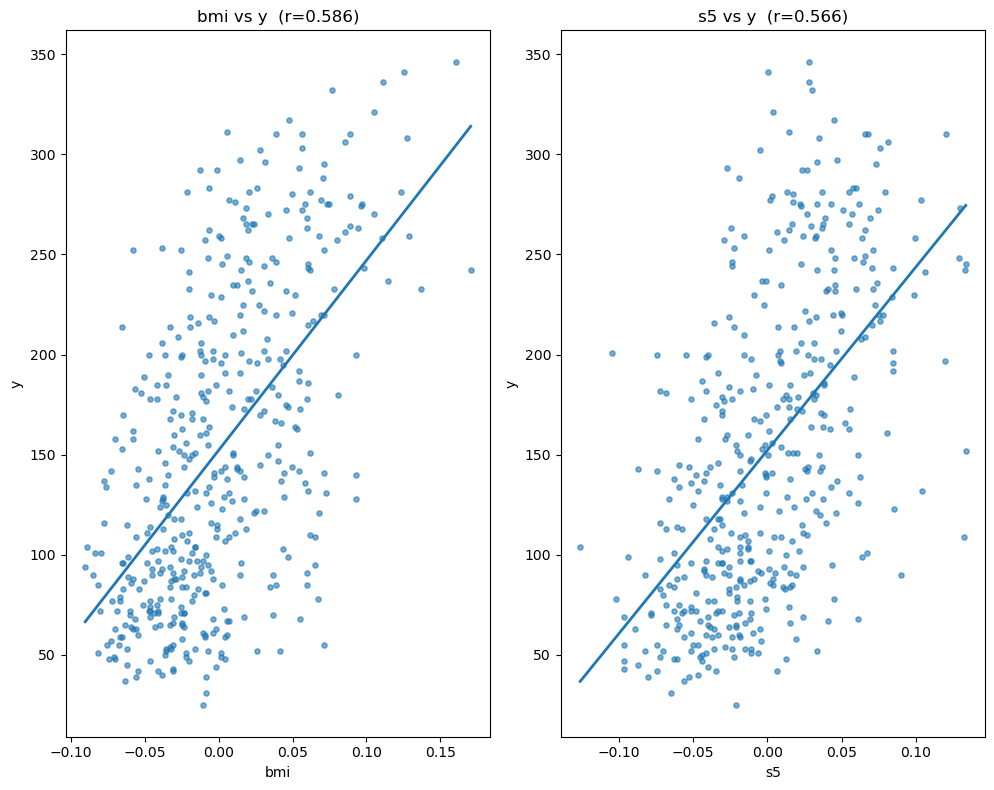

In [361]:
# === 선택 컬럼 vs 타깃(y) 시각화: 산점도 + 직선 추세선 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SELECTED = ['bmi', 's5']

# 0) df_X, df_y가 이미 있다면 그대로 사용하고,
#    없으면 sklearn.load_diabetes()로 생성합니다.
try:
    df_X
    df_y
except NameError:
    from sklearn.datasets import load_diabetes
    data = load_diabetes()
    df_X = pd.DataFrame(data.data, columns=data.feature_names)
    df_y = pd.Series(data.target, name="y")

# 1) 선택 컬럼만 추리기 (없는 컬럼은 자동 제거)
features = [c for c in SELECTED if c in df_X.columns]
assert len(features) > 0, "선택한 컬럼이 df_X에 없습니다."

X = df_X[features].copy()
y = pd.Series(df_y, name="y")

# 2) 그리드 설정 (5개면 2x3 그리드로 하나 비움)
n = len(features)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = np.array(axes).reshape(-1)  # 1차원으로

for ax, col in zip(axes, features):
    xi = X[col].values
    yi = y.values

    # 산점도
    ax.scatter(xi, yi, s=14, alpha=0.6)

    # 직선 추세선 (최소제곱 1차)
    m, b = np.polyfit(xi, yi, 1)
    xline = np.linspace(xi.min(), xi.max(), 200)
    yline = m * xline + b
    ax.plot(xline, yline, linewidth=2)

    # 피어슨 상관
    r = np.corrcoef(xi, yi)[0, 1]

    ax.set_title(f"{col} vs y  (r={r:.3f})")
    ax.set_xlabel(col)
    ax.set_ylabel("y")

# 남는 축 삭제
for k in range(n, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


In [362]:
import numpy as np
X = np.array(df_X1)
print(type(X), X.dtype)

<class 'numpy.ndarray'> float64


In [363]:
y = np.array(df_y)

print(type(y), y.dtype)

<class 'numpy.ndarray'> float64


In [364]:
# train-test 데이터 분리

from sklearn.model_selection import train_test_split

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(353, 5) (353,)
(89, 5) (89,)


In [366]:
# 모델 준비하기

W = np.random.rand(X_train.shape[1])
b = np.random.rand()

print(len(W))

5


In [367]:
def model(X, W, b):
    predictions = 0
    for i in range(len(W)):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

In [368]:
# 손실함수 loss 정의하기
def MSE(a, b):
    mse = ((a - b) **2).mean()
    return mse

In [369]:
def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

In [370]:
# 기울기를 구하는 gradient 함수 구현
def gradient(X, W, b, y):
    N = len(y)

    y_pred = model(X, W, b)

    
    dW = 1/N *2 * X.T.dot(y_pred -y)
    db = 2 * (y_pred -y).mean()
    return dW, db


In [371]:
# 하이퍼 파라미터인 학습률 설정하기
LEARNING_RATE = 0.2

In [372]:
%%timeit -n 1 -r 1
global W, b

losses = []

for i in range(1, 1001):
    dW, db = gradient(X_train, W, b, y_train)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(X_train, W, b, y_train)
    losses.append(L)
    if i % 100 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 100 : Loss 5007.3940
Iteration 200 : Loss 4356.2785
Iteration 300 : Loss 3950.6308
Iteration 400 : Loss 3695.6986
Iteration 500 : Loss 3533.5398
Iteration 600 : Loss 3428.6971
Iteration 700 : Loss 3359.4500
Iteration 800 : Loss 3312.4730
Iteration 900 : Loss 3279.5731
Iteration 1000 : Loss 3255.6972
78.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [373]:
# test 데이터 에 대한 성능확인하기

prediction = model(X_test, W, b)
mse = loss(X_test, W, b, y_test)
mse

np.float64(2945.882974546338)

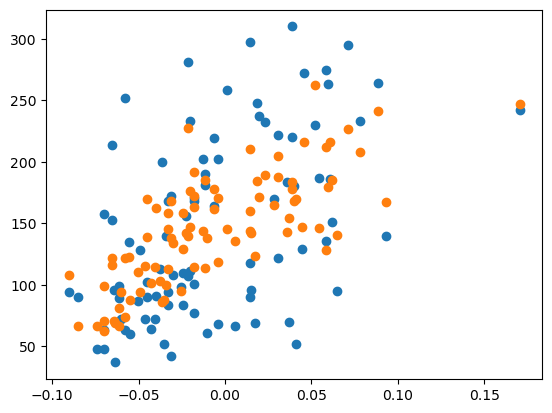

In [374]:
# 정답 데이터와 예측한 데이터 시각화
import matplotlib.pyplot as plt

plt.scatter(X_test[:, 0], y_test)
plt.scatter(X_test[:, 0], prediction)
plt.show()